In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## **Task**

We want to train an MLP to learn the construction of names. To achieve this we want to maximise the likelihood of the $N$ names observed in the dataset:

$$
\max_{\theta} \sum_{i=1}^{N} \hat{p}(\mathbf{x}_i) = \max_{\theta} \sum_{i=1}^{N} \prod_{j=1}^{M_i} \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta)
$$

In particular, we choose to break down the probability of a name into the product of the conditional probabilities of each character given a $k$-letter context window (we use '.' as the special token to pad the start and end of a name). For example, the name "John" would give us the following data points:

* ... $\rightarrow$ J
* ..J $\rightarrow$ o
* .Jo $\rightarrow$ h
* Joh $\rightarrow$ n
* ohn $\rightarrow$ .

We begin by constructing a training set of such data points from all the names in the dataset. We then use the negative log-likelihood of the data as the loss function to be minimized. See `mm_intro.ipynb` for more details.

# **Dataset**

In [2]:
# Load data
words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Create a dictionary that maps characters to integers and vice versa
char2idx = {c: i+1 for i, c in enumerate('abcdefghijklmnopqrstuvwxyz')}
char2idx['.'] = 0 # special character for marking start and end of a word
idx2char = {i: c for c, i in char2idx.items()}

In [4]:
# Form training pairs (context, target characters)
block_size = 8 # context size for next character prediction

def build_dataset(words):
    X, Y = [], []
    for word in words:
        w2idx = [0] * block_size + [char2idx[c] for c in word] + [0]
        for i in range(len(w2idx) - block_size):
            X.append(w2idx[i:i+block_size])
            Y.append(w2idx[i+block_size])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape, X.dtype, Y.dtype)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train, Y_train = build_dataset(words[:n1]) # 80% of words
X_val, Y_val = build_dataset(words[n1:n2]) # 10% of words
X_test, Y_test = build_dataset(words[n2:]) # 10% of words

# print first 10 samples of X_train and Y_train
for i in range(len(Y_train[:10])):
    print(''.join([idx2char[idx.item()] for idx in X_train[i]]), '->', idx2char[Y_train[i].item()])

torch.Size([182625, 8]) torch.Size([182625]) torch.int64 torch.int64
torch.Size([22655, 8]) torch.Size([22655]) torch.int64 torch.int64
torch.Size([22866, 8]) torch.Size([22866]) torch.int64 torch.int64
........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
........ -> d
.......d -> i
......di -> o


# **Model**

In this notebook, we will build a WaveNet model to learn the construction of names. In particular, we look to the paper [WaveNet: A Generative Model for Raw Audio](https://arxiv.org/abs/1609.03499) for inspiration. In the context of our task, we will be using a _stack of dilated causal convolutional layers_ (see Figure 3 in the paper) over an $8$-letter context window to model the conditional probabilities of each character given the context window. That is, neighbouring sequences of characters are joined pairwise without overlap in a serial manner until the entire sequence is reduced to a single output at the root (think the conquer part of _divide and conquer_). The leaf nodes are the individual characters in the context window.

For an efficient implementation of this model, we will find it useful to exploit the power of the matrix-multiplication operator `@` in PyTorch. In particular, we will use the observation that the matrix-multiplication essentially operates only on the last dimension of the input tensor. E.g., the following two operations are equivalent:

```python
# 1. Using matrix-multiplication
x = torch.randn(2, 3, 4)
y = torch.randn(4, 5)
z = x @ y

# 2. Using einsum
z = torch.einsum('ijk,kl->ijl', x, y)

# 3. Using view
z = torch.matmul(x.view(-1, 4), y).view(2, 3, 5)
```

In essence, it simply applies a transformation along the last dimension of the input tensor. So for our model with $k=8$ leaf nodes, we will have 3 hidden layers in order to transform the input sequence of $8$ characters into a single output that has tied together all the characters in the sequence. The following diagram illustrates the model architecture: 

$$
\begin{align*}
&[32, 8] \xrightarrow{\text{Embedding}} [32, 8, d_{\text{emb}}] \\
&\qquad \xrightarrow{\text{FlattenConsecutive}} [32, 4, 2{*}d_{\text{emb}}] \xrightarrow{\text{H. Layer 1}} [32, 4, d_{\text{hidden}}] \xrightarrow{\text{BN 1}} [32, 4, d_{\text{hidden}}] \xrightarrow{\text{Tanh}} [32, 4, d_{\text{hidden}}] \\
&\qquad \qquad \xrightarrow{\text{FlattenConsecutive}} [32, 2, 2{*}d_{\text{hidden}}] \xrightarrow{\text{H. Layer 2}} [32, 2, d_{\text{hidden}}] \xrightarrow{\text{BN 2}} [32, 2, d_{\text{hidden}}] \xrightarrow{\text{Tanh}} [32, 2, d_{\text{hidden}}] \\
&\qquad \qquad \qquad \xrightarrow{\text{FlattenConsecutive}} [32, 2{*}d_{\text{hidden}}] \xrightarrow{\text{H. Layer 3}} [32, d_{\text{hidden}}] \xrightarrow{\text{BN 3}} [32, d_{\text{hidden}}] \xrightarrow{\text{Tanh}} [32, d_{\text{hidden}}] \\
&\qquad \qquad \qquad \qquad \xrightarrow{\text{Output Layer}} [32, 27] \\
\end{align*}
$$

where $d_{\text{emb}}$ and $d_{\text{hidden}}$ are the embedding and hidden dimensions respectively. The $\text{FlattenConsecutive(n)}$ layer is a custom layer that flattens consecutive dimensions of the input tensor. For example, if the input tensor has shape $[B, T, C]$, then the output tensor will have shape $[B, T/n, C{*}n ]$. This is used for the "conquer" approach mentioned above. The $\text{OutputLayer}$ is a linear layer that maps the hidden representation to a vector of size $27$ (the number of characters in the vocabulary). The $\text{BN}$ layers are batch-normalization layers that help with training the model. 

An important point to make is that the BatchNorm computes and tracks the mean and variance over the first two dimensions of the input tensor. E.g., for the input shape $[32, 4, 64]$, the mean and variance computed by the BatchNorm will have the shape $[1, 1, 64]$. Alternatively, we could compute the mean and variance only over the first dimension to get a shape of $[1, 4, 64]$, however, this is a smaller batch size and so the statistics will be less accurate and the performance of the model will suffer. See [Andrej Karpathy's video](https://youtu.be/t3YJ5hKiMQ0?t=2330) for more details.

In [5]:
class Embedding:
    def __init__(self, num_embeddings, emb_dim):
        self.W = torch.randn((num_embeddings, emb_dim)) # / dim**0.5

    def __call__(self, x):
        self.out = self.W[x]
        return self.out
    
    def parameters(self):
        return [self.W]

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.b = torch.zeros((fan_out)) if bias else None
 
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        if self.b is not None:
            return [self.W, self.b]
        else:
            return [self.W]
        
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.gain = torch.ones((dim))
        self.bias = torch.zeros((dim))
        self.eps = eps
        self.training = True
        self.momentum = momentum
        self.mean_running = torch.zeros((dim))
        self.var_running = torch.ones((dim))

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        else:
            x_mean = self.mean_running
            x_var = self.var_running
        x_hat = (x - x_mean) / (x_var + self.eps).sqrt()
        self.out = self.gain * x_hat + self.bias
        if self.training:
            with torch.no_grad():
                self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * x_mean
                self.var_running = (1 - self.momentum) * self.var_running + self.momentum * x_var
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n  

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [6]:
torch.manual_seed(42); # seed RNG for reproducibility

In [7]:
emb_dim = 10 # embedding dimension
h_dim = 68 # hidden layer dimension

model = Sequential([
    Embedding(27, emb_dim), 
    FlattenConsecutive(2), Linear(emb_dim * 2, h_dim, bias=False), BatchNorm1d(h_dim), Tanh(),
    FlattenConsecutive(2), Linear(h_dim * 2, h_dim, bias=False), BatchNorm1d(h_dim), Tanh(),
    FlattenConsecutive(2), Linear(h_dim * 2, h_dim, bias=False), BatchNorm1d(h_dim), Tanh(),
    Linear(h_dim, 27)
])

with torch.no_grad():
    model.layers[-1].W *= 0.1 # make last linear layer less confident (more uniform) predictions

parameters = model.parameters()
print('Number of parameters:', sum([p.numel() for p in parameters]))

# Always perform last 
for p in parameters:
    p.requires_grad = True

Number of parameters: 22397


In [ ]:
# For checking the shapes of the outputs of each layer are correct
for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)

## Training

In [8]:
# Training parameters
max_steps = 200000
batch_size = 32
loss_i = []
upd2data = []

In [9]:
# Training loop
for i in range(max_steps):
    # mini-batch sampling
    batch_idxs = torch.randperm(len(Y_train))[:batch_size]
    X_batch, Y_batch = X_train[batch_idxs], Y_train[batch_idxs]
  
    # forward pass
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.1 if i < 150000 else 0.01 # decrease learning rate after 150K steps
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())
    # with torch.no_grad():
    #     upd2data.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.3155
   1000/ 200000: 2.2332
   2000/ 200000: 2.2421
   3000/ 200000: 2.2549
   4000/ 200000: 2.0909
   5000/ 200000: 1.9791
   6000/ 200000: 2.5362
   7000/ 200000: 1.8855
   8000/ 200000: 2.2033
   9000/ 200000: 2.1508
  10000/ 200000: 2.4661
  11000/ 200000: 1.8528
  12000/ 200000: 2.1775
  13000/ 200000: 2.1622
  14000/ 200000: 2.3552
  15000/ 200000: 1.7879
  16000/ 200000: 2.5190
  17000/ 200000: 2.1064
  18000/ 200000: 2.0279
  19000/ 200000: 2.2067
  20000/ 200000: 2.1264
  21000/ 200000: 2.0702
  22000/ 200000: 2.1656
  23000/ 200000: 1.8475
  24000/ 200000: 2.2468
  25000/ 200000: 2.0848
  26000/ 200000: 2.2916
  27000/ 200000: 1.8310
  28000/ 200000: 2.0047
  29000/ 200000: 2.0145
  30000/ 200000: 2.4335
  31000/ 200000: 2.1779
  32000/ 200000: 2.1282
  33000/ 200000: 1.9397
  34000/ 200000: 2.0702
  35000/ 200000: 2.0301
  36000/ 200000: 2.2743
  37000/ 200000: 1.8982
  38000/ 200000: 2.2299
  39000/ 200000: 1.9268
  40000/ 200000: 1.9853
  41000/ 200000:

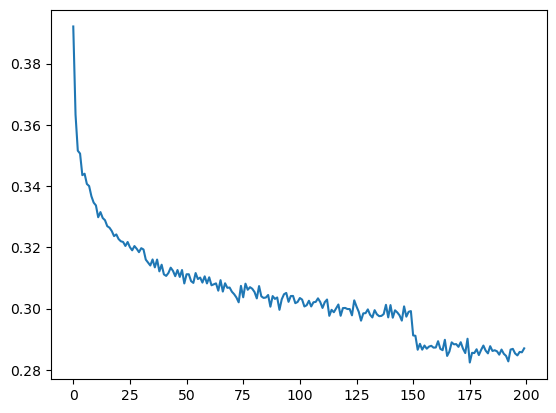

In [10]:
# We smoothen out the loss curve by averaging over 1000 steps
# Due to the small batch size of 32, it would be too noisy otherwise
plt.plot(torch.tensor(loss_i[len(loss_i) % 1000:]).view(-1, 1000).mean(1));

## Validation

In [11]:
# put layers into eval mode (needed for batch norm especially)
for l in model.layers:
    l.training = False

In [12]:
# forward pass for loss validation
@torch.no_grad() # this decorator disables gradient tracking
def split_losss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split] 
    logits = model(x)
    loss = F.cross_entropy(logits, y) 
    print('Loss:', loss.item())

split_losss('train')
split_losss('val')

Loss: 1.9130065441131592
Loss: 2.0279746055603027


## Inference

In [13]:
for _ in range(10):
    name = ''
    context = [0] * block_size
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample next character
        i = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [i]
        name += idx2char[i]
        if i == 0: 
            break
    print(name)

zyea.
nolie.
kailon.
mary.
tyrtzee.
caseey.
kamellin.
mcky.
havani.
deagrutkuci.


## Using Convolutional Layers

The linear layers of the model can in fact be implemented using convolutional layers which would be a lot more efficient if we needed to process a number of samples that are consecutive, e.g. during inference. For example, consider the following samples:

```
........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
```
Using convolutional layers one could process all these samples in parallel, in an online fashion. In contrast to an explicit for-loop that is needed with the linear layer approach we adopted above, a convolutional approach would have the for-looping (sliding of a filter over the input samples) baked into the convolutional layers that run on the GPU, making it much more efficient.